In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kstest, norm

# Color class for prettier formatting
class Color:
   GREEN = '\033[92m'
   RED = '\033[91m'

# 1) Loading dataset

In [2]:
file = "data/bank-additional.csv"

dataset = pd.read_csv(file, sep=";")

In [3]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2.0,999,0.0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4.0,999,0.0,nonexistent,1.1,93.994,-36.4,4.855,5191,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1.0,999,0.0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3.0,999,0.0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1.0,999,0.0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [4]:
dataset.y.value_counts()

y
no     3667
yes     451
Name: count, dtype: int64

In [5]:
rows, cols = dataset.shape

print("Shape of dataset")
print(20*'-')
print(f"No of rows: {rows}\nNo of cols: {cols}")
print(20*'-')

Shape of dataset
--------------------
No of rows: 4119
No of cols: 21
--------------------


# 2) Dataset analysis

## Data types

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4116 non-null   float64
 11  campaign        4114 non-null   float64
 12  pdays           4119 non-null   int64  
 13  previous        4117 non-null   float64
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4116 non-null   float64
 16  cons.price.idx  4117 non-null   float64
 17  cons.conf.idx   4117 non-null   f

<b>Comment:</b> 

For some reason, "nr.employed" is object, but it's supposed to be numeric. We are going to examine why that happened.

In [7]:
dataset['nr.employed'].value_counts()

nr.employed
5228.1    1625
5099.1     822
5191       758
5195.8     392
5076.2     164
5017.5     104
4991.6      87
4963.6      83
5008.7      60
5023.5      21
no           1
5176.3       1
Name: count, dtype: int64

<b>Conclusion:</b> 

It can be seen there is one instance that contains value "no". That row will be removed from the dataset.

In [8]:
dataset.drop(labels=dataset.loc[dataset['nr.employed'] == "no", :].index, inplace=True)

Now column 'nr.employed' is ready to be casted into float64.

In [9]:
dataset['nr.employed'] = pd.to_numeric(dataset['nr.employed'])

In [10]:
dataset['nr.employed'].dtype

dtype('float64')

## Correlation

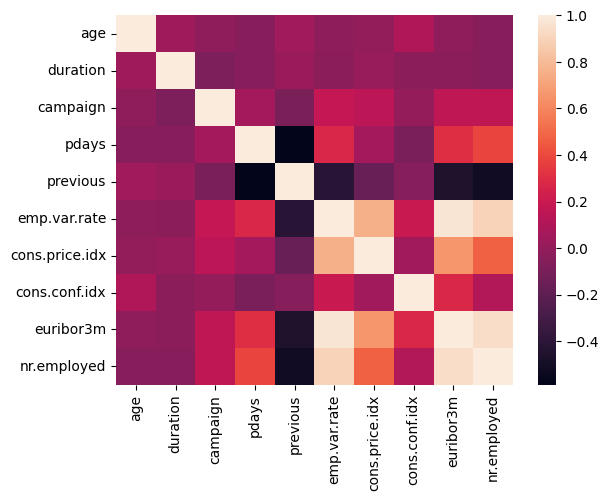

In [11]:
sns.heatmap(dataset.select_dtypes(np.number).corr(method='pearson'));

<b>Conclusion:</b> 

Highly + correlated (~0.8):
<ul>
    <li>"cons.price.idx" and "emp.var.rate"</li>
</ul>

High - correlation:
<ul>
    <li>"previous" and "pdays" (-0.59)</li>
    <li>"previous" and "emp.var.rate" (-0.41)</li>
</ul>

## NaN Values

In [12]:
nas = dataset.isna().agg(["sum", "count"]).transpose()
nas["sum_%"] = nas["sum"] / nas["count"] * 100

In [13]:
nas

,sum,count,sum_%
age,0,4118,0.000000
job,0,4118,0.000000
marital,0,4118,0.000000
education,0,4118,0.000000
default,0,4118,0.000000
housing,0,4118,0.000000
loan,0,4118,0.000000
contact,0,4118,0.000000
month,0,4118,0.000000
day_of_week,0,4118,0.000000


#### Dropping nans of class columns

In [14]:
# doesn't work with dataset.loc[:,'y'].dropna(inplace=True)
dataset.dropna(subset="y", inplace=True)

#### Replacing nan's with mode for categorical or median for numerical

In [15]:
nas_columns = list(nas[nas["sum"] > 0].index)

for col in nas_columns:
    if dataset[col].dtypes == "object":
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)
    else:
        dataset[col].fillna(dataset[col].median(), inplace=True)    

In [16]:
dataset.isna().sum().sum()

0

## Inspecting categorical features

In [17]:
# extract categorical columns
cols_categ = dataset.select_dtypes(include="object").columns.tolist()

# excluding y columns
cols_categ = cols_categ[:-1]
cols_categ

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [18]:
def autopct_format_perc_vals(values):
    """
    Decorator to show both percentages and actual values on pie chart.    
    
    Parameters:
        values (str): Values to be shown on pie chart.
    Returns:
        None
    """
    
    total = sum(values)

    def my_format(pct):
        vals = total*pct/100
        return "{:.2f}%\n[{:.0f}]".format(pct, vals)
    return my_format

In [19]:
#script for automatic visualization of attributes using pie or bar chart
#
#params: 
#  column column of dataset on which pie chart will be plotted 
def script_1(column, labels=None):

    plt.figure(figsize=(8,8))
        
    table_value_counted = dataset[column].value_counts()
    
    # print(f"Column {column}")
        
    #plotting pie chart
    if table_value_counted.size <= 5:
        plt.pie(table_value_counted, 
                autopct=autopct_format_perc_vals(table_value_counted),
           labels=labels if labels else table_value_counted.index)

    #plotting bar chart
    else:       
        plt.bar(table_value_counted.index, table_value_counted)
        plt.xticks(rotation='vertical')
        #get current axes
        ax = plt.gca()

        #foor loop to show both percentage and values above bars using annotate function
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            
            pct = height / table_value_counted.sum()*100
            
            ax.annotate("{:.2f}%\n[{:.0f}]".format(pct, height), (x + width/2, y + height*1.016), ha='center')
    
    
    plt.xlabel(f"Percentage & frequency of people for column {column}", size=14);

In [20]:
def custom_value_counts(column):
    print(50*"-")
    print(dataset[column].value_counts())
    print(50*"-")
    print()

#### Column 'job'

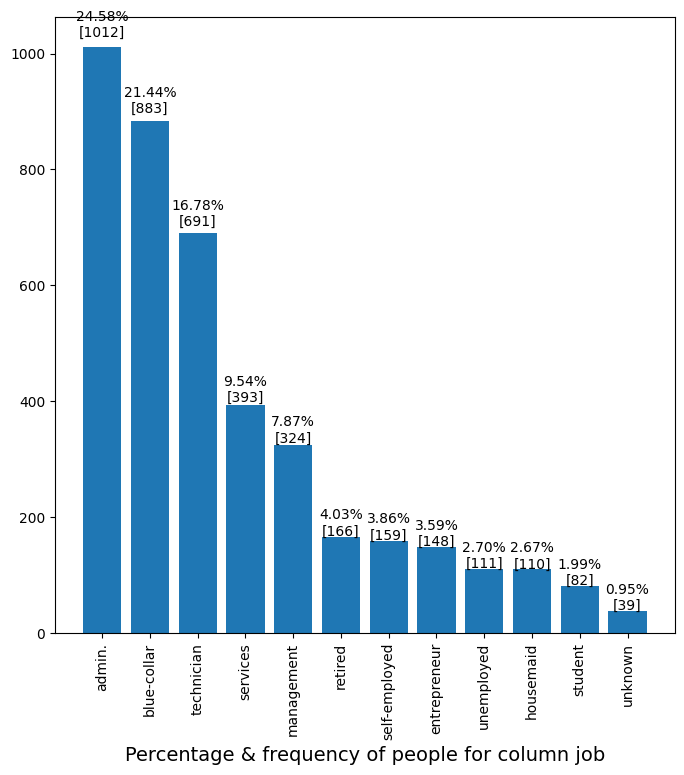

In [21]:
col = 'job'

script_1(col)

In [22]:
dataset.drop(labels=dataset.loc[dataset[col] == "unknown", :].index, inplace=True)

In [23]:
custom_value_counts(col)

--------------------------------------------------
job
admin.           1012
blue-collar       883
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
Name: count, dtype: int64
--------------------------------------------------



#### Column 'marital'

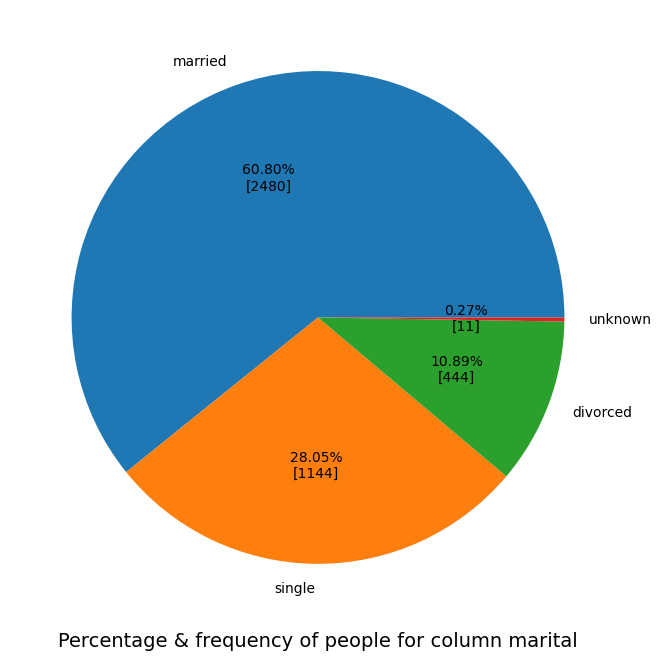

In [24]:
col = 'marital'

script_1(col)

In [25]:
dataset.drop(labels=dataset.loc[dataset[col] == "unknown", :].index, inplace=True)

In [26]:
custom_value_counts(col)

--------------------------------------------------
marital
married     2480
single      1144
divorced     444
Name: count, dtype: int64
--------------------------------------------------



#### Column 'education'

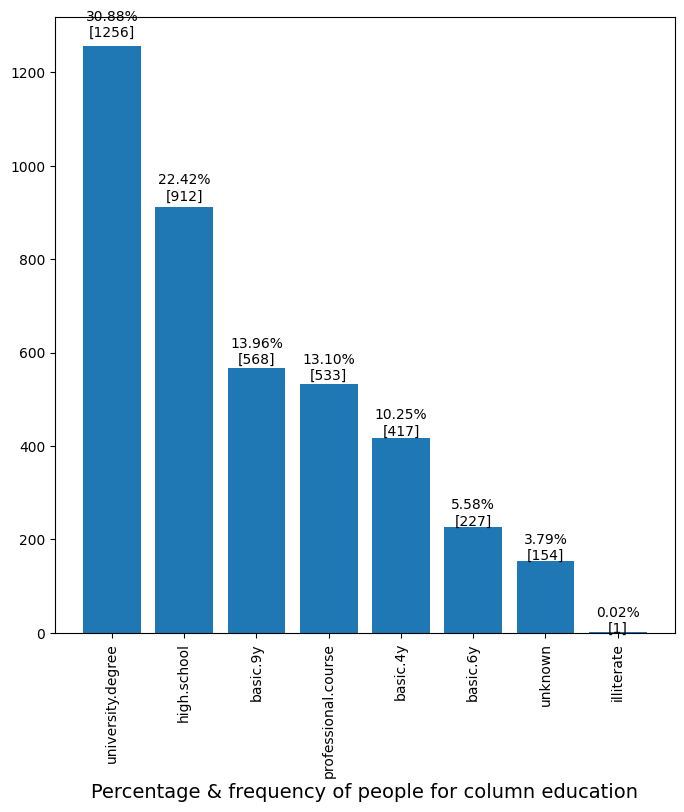

In [27]:
col = 'education'

script_1(col)

<b>Comment:</b> 

Dropping illiterate category, since only one person belongs there.

In [28]:
dataset.drop(labels=dataset.loc[dataset[col] == "illiterate", :].index, inplace=True)
dataset.drop(labels=dataset.loc[dataset[col] == "unknown", :].index, inplace=True)

custom_value_counts(col)

--------------------------------------------------
education
university.degree      1256
high.school             912
basic.9y                568
professional.course     533
basic.4y                417
basic.6y                227
Name: count, dtype: int64
--------------------------------------------------



#### Column 'default'

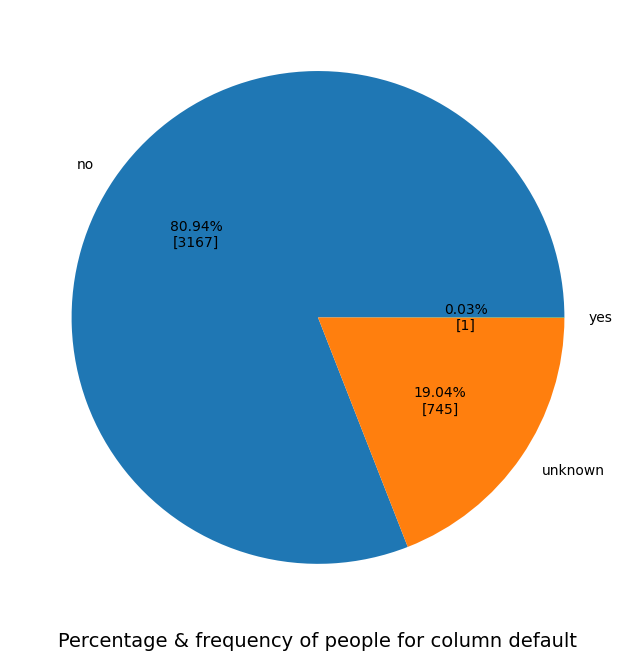

In [29]:
col = 'default'

script_1(col);

In [30]:
dataset.drop(columns=col, inplace=True)

#### Column 'housing'

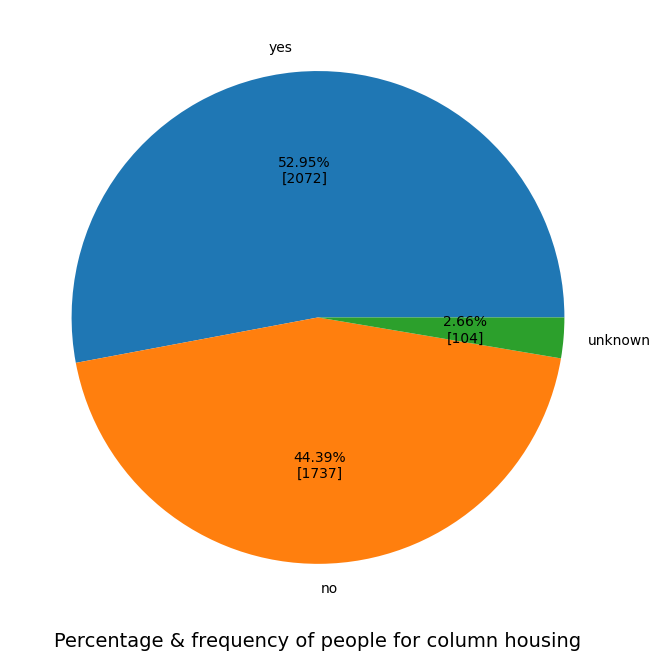

In [31]:
col = 'housing'

script_1(col)

In [32]:
dataset.drop(labels=dataset.loc[dataset[col] == "unknown", :].index, inplace=True)

custom_value_counts(col)

--------------------------------------------------
housing
yes    2072
no     1737
Name: count, dtype: int64
--------------------------------------------------



#### Column 'loan'

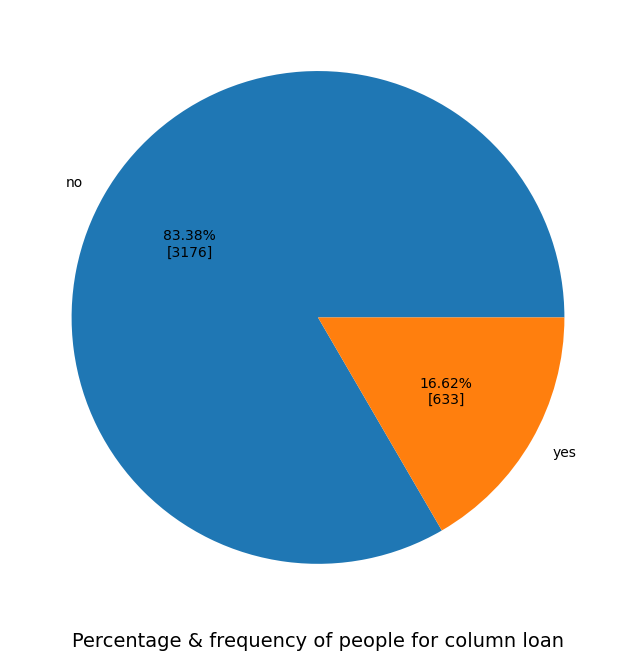

In [33]:
col = 'loan'

script_1(col)

In [34]:
dataset.drop(labels=dataset.loc[dataset[col] == "unknown", :].index, inplace=True)

custom_value_counts(col)

--------------------------------------------------
loan
no     3176
yes     633
Name: count, dtype: int64
--------------------------------------------------



#### Column 'contact'

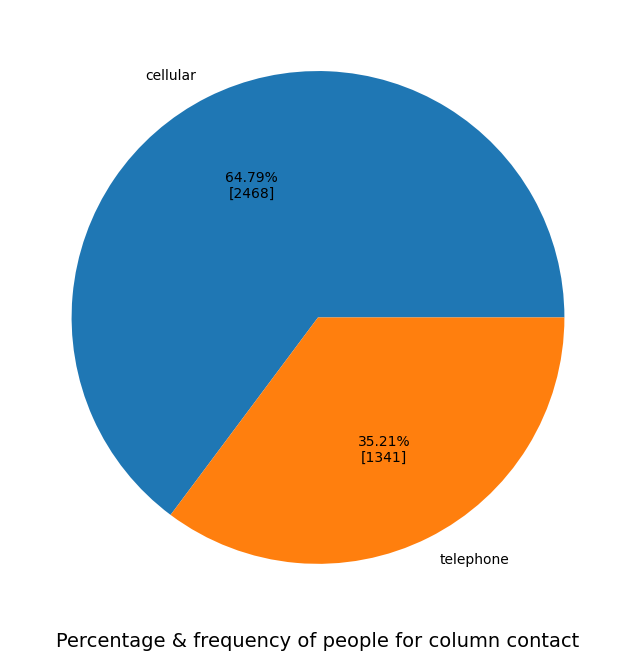

In [35]:
col = 'contact'

script_1(col)

#### Column 'month'

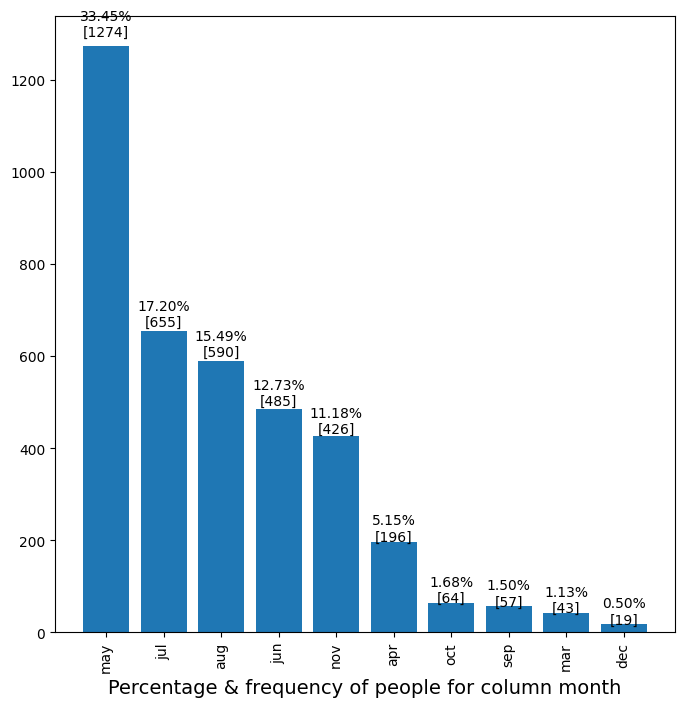

In [36]:
col = 'month'

script_1(col)

#### Column 'day_of_week'

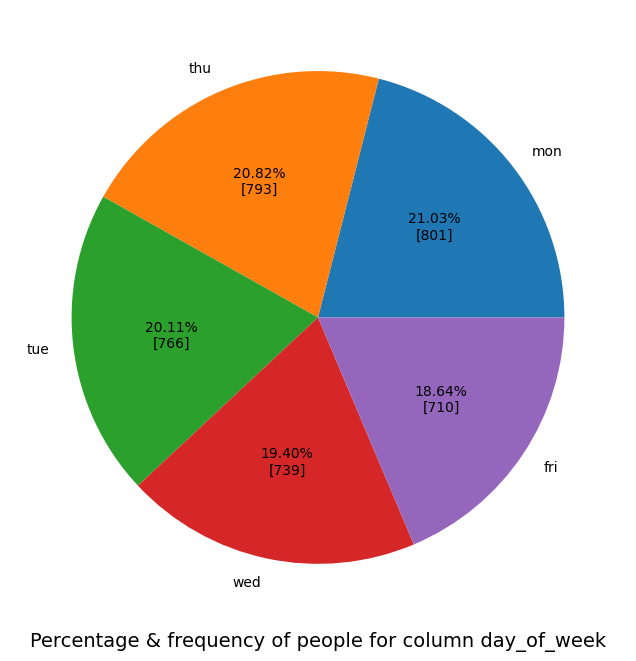

In [37]:
col = 'day_of_week'

script_1(col)

#### Column 'poutcome'

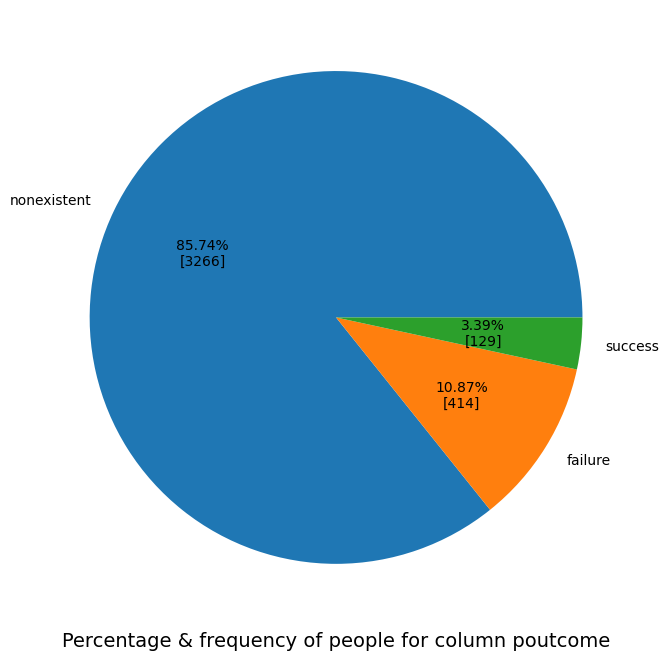

In [38]:
col = 'poutcome'

script_1(col)

We shouldn't treat 'nonexistent' values as nans.

##  Inspecting numerical features

In [39]:
cols_numer = dataset.select_dtypes(include=[np.number]).columns.tolist()
cols_numer

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

### Column 'age'

#### Boxplot

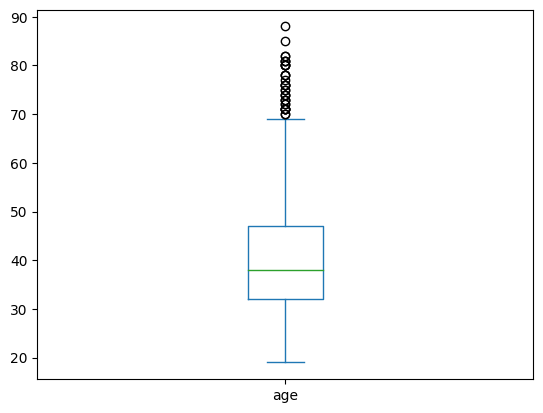

In [40]:
col = cols_numer[0]

dataset[col].plot.box();

In [41]:
dataset[col].describe()

count    3809.000000
mean       39.963507
std        10.217693
min        19.000000
25%        32.000000
50%        38.000000
75%        47.000000
max        88.000000
Name: age, dtype: float64

#### Histogram & K-S test

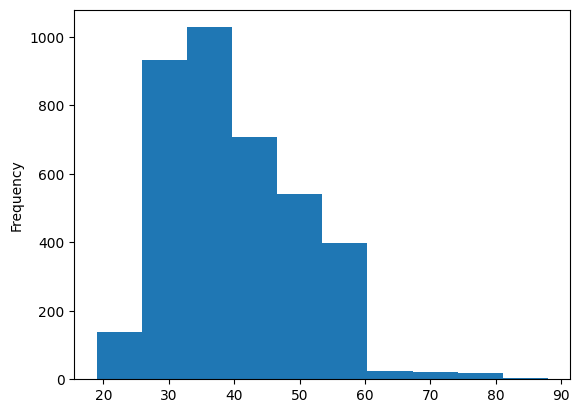

In [42]:
dataset[col].plot.hist();

In [43]:
# Calculating p_value of the column
p_value = kstest(dataset[col], norm(loc=dataset[col].mean(), scale=dataset[col].std()).cdf)[1]

if p_value > 0.05:
    print(Color.GREEN + f'"{col}" column has a normal distribution. \nSig: {p_value}\n')
else:
    print(Color.RED + f'"{col}" column does not have a normal distribution. \nSig: {p_value}\n')

"age" column does not have a normal distribution. 
Sig: 2.290940330924595e-33



### Column 'duration'

#### Boxplot

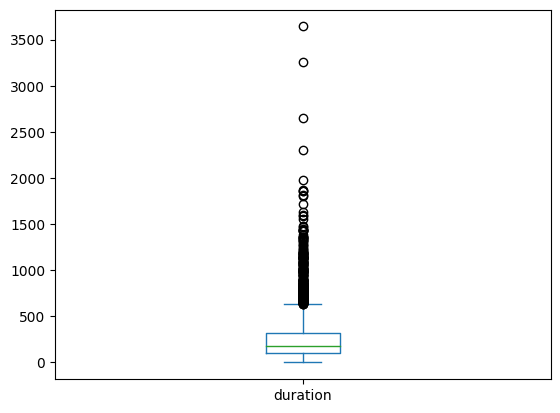

In [44]:
col = cols_numer[1]

dataset[col].plot.box();

#### Histogram

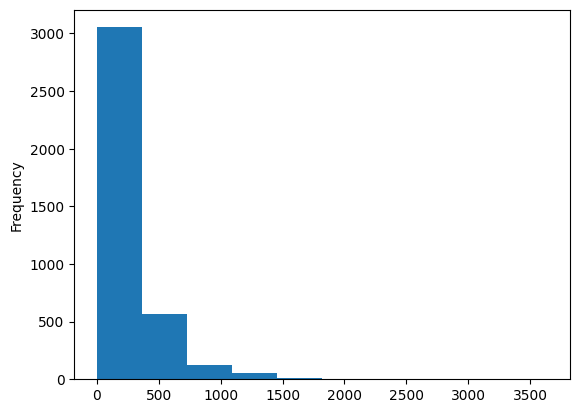

In [45]:
dataset[col].plot.hist();

In [46]:
dataset[col].describe()

count    3809.000000
mean      256.555264
std       256.863017
min         0.000000
25%       103.000000
50%       180.000000
75%       316.000000
max      3643.000000
Name: duration, dtype: float64

In [47]:
dataset.drop(labels=dataset.loc[dataset[col] >  3000, :].index, inplace=True)

### Column 'campaign'

#### Boxplot

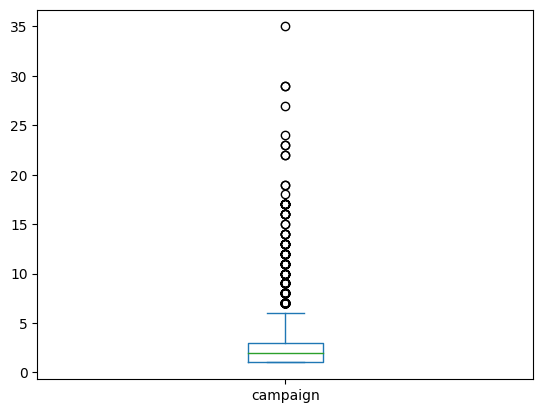

In [48]:
col = cols_numer[2]

dataset[col].plot.box();

#### Histogram

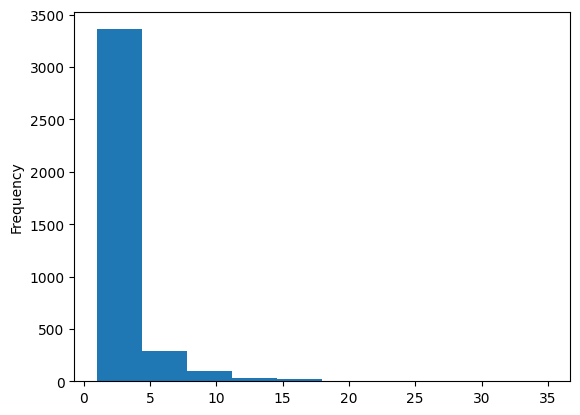

In [49]:
dataset[col].plot.hist();

In [50]:
dataset[col].describe()

count    3807.000000
mean        2.536906
std         2.588860
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        35.000000
Name: campaign, dtype: float64

### Column 'pdays'

#### Boxplot

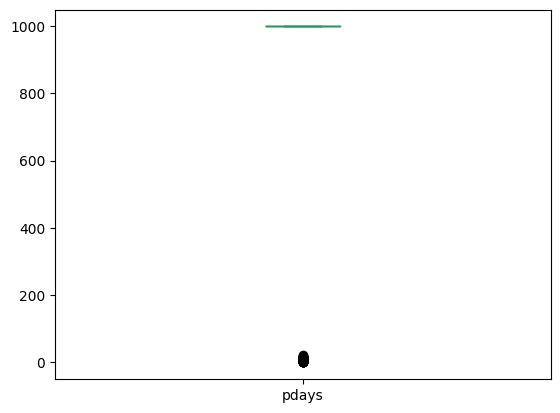

In [51]:
col = cols_numer[3]

dataset[col].plot.box();

In [52]:
dataset[col].describe()

count    3807.000000
mean      961.427896
std       189.523446
min         0.000000
25%       999.000000
50%       999.000000
75%       999.000000
max       999.000000
Name: pdays, dtype: float64

#### Histogram & K-S test

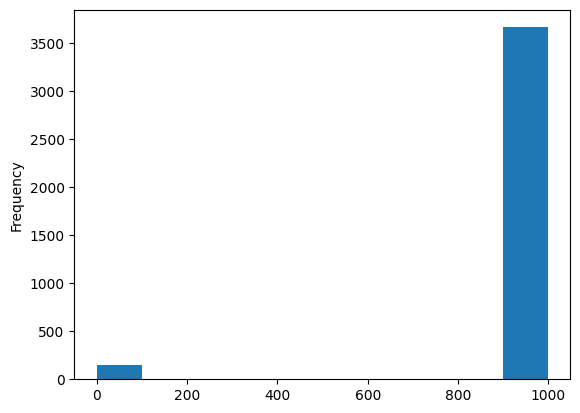

In [53]:
dataset[col].plot.hist();

People who have value of pdays 999 means the client was not previously contacted. Thus this variable can be of greater use if transformed into ordinal variable.

#### Discretizing

In [54]:
dataset[col].replace(999, -1, inplace=True)

dataset[col] = pd.cut(dataset[col],
       bins=[-1.1, 0, 7, 14, 21], 
       labels=["NotContacted", "[0-7)", "[7-14)", "[14, 21]"])

dataset[col].value_counts()

pdays
NotContacted    3665
[0-7)            117
[7-14)            19
[14, 21]           6
Name: count, dtype: int64

### Column 'previous'

#### Boxplot

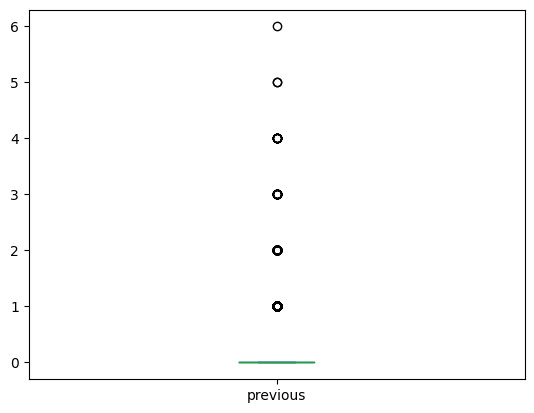

In [55]:
col = cols_numer[4]

dataset[col].plot.box();

#### Histogram & K-S test

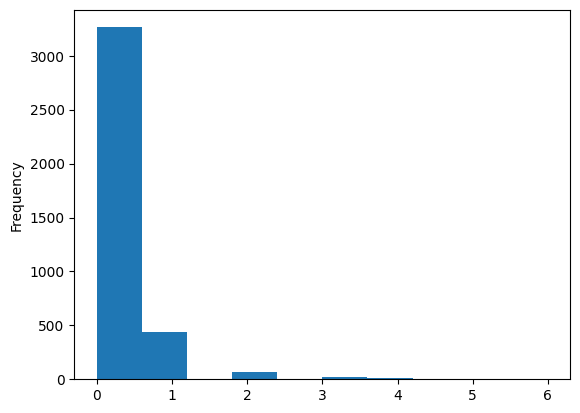

In [56]:
dataset[col].plot.hist();

In [57]:
dataset[col].describe()

count    3807.000000
mean        0.184397
std         0.523377
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: previous, dtype: float64

### Column 'emp.var.rate'

#### Boxplot

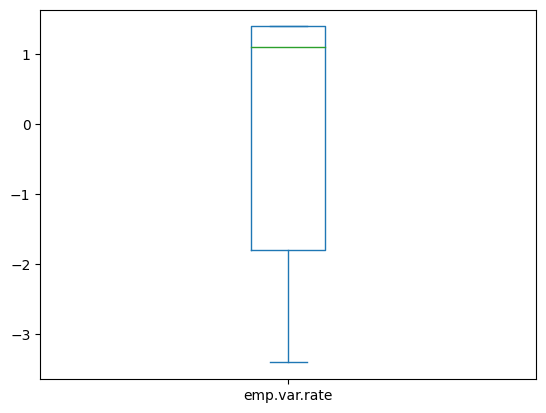

In [58]:
col = cols_numer[5]

dataset[col].plot.box();

#### Histogram & K-S test

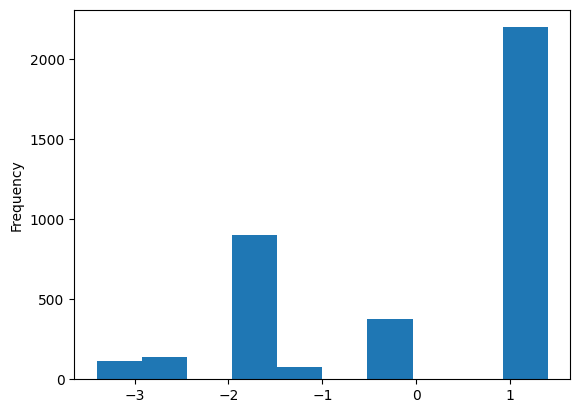

In [59]:
dataset[col].plot.hist();

In [60]:
dataset[col].describe()

count    3807.000000
mean        0.089598
std         1.556684
min        -3.400000
25%        -1.800000
50%         1.100000
75%         1.400000
max         1.400000
Name: emp.var.rate, dtype: float64

### Column 'cons.price.idx'

#### Boxplot

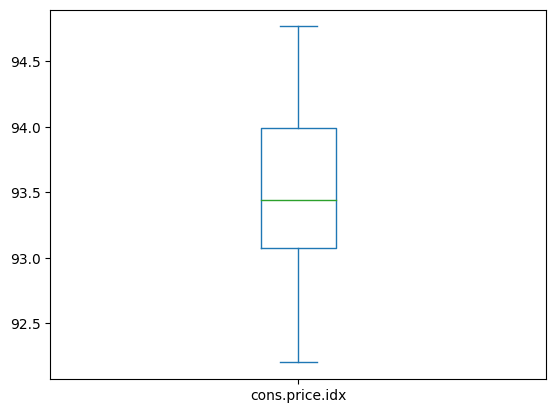

In [61]:
col = cols_numer[6]

dataset[col].plot.box();

In [62]:
dataset[col].describe()

count    3807.000000
mean       93.575871
std         0.578345
min        92.201000
25%        93.075000
50%        93.444000
75%        93.994000
max        94.767000
Name: cons.price.idx, dtype: float64

#### Histogram & K-S test

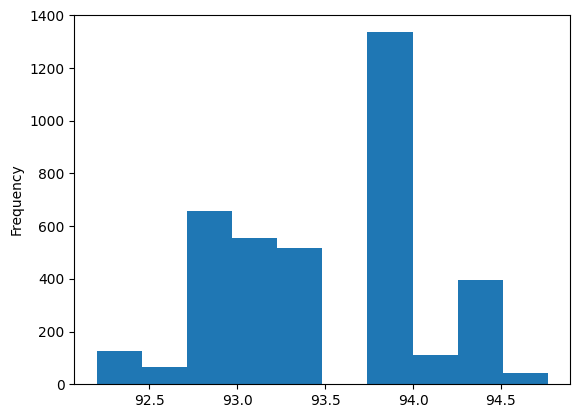

In [63]:
dataset[col].plot.hist();

In [64]:
# Calculating p_value of the column
p_value = kstest(dataset[col], norm(loc=dataset[col].mean(), scale=dataset[col].std()).cdf)[1]

if p_value > 0.05:
    print(Color.GREEN + f'"{col}" column has a normal distribution. \nSig: {p_value}\n')
else:
    print(Color.RED + f'"{col}" column does not have a normal distribution. \nSig: {p_value}\n')

"cons.price.idx" column does not have a normal distribution. 
Sig: 2.711586023133774e-147



### Column 'cons.conf.idx'

#### Boxplot

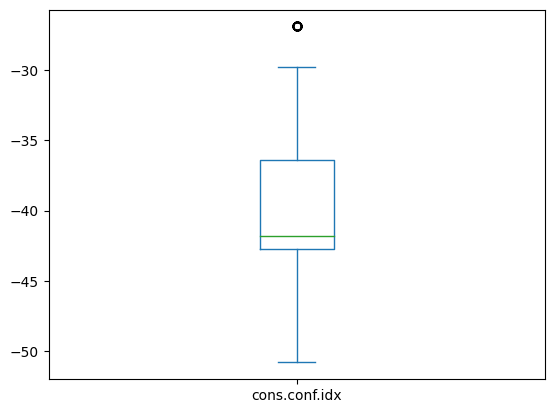

In [65]:
col = cols_numer[7]

dataset[col].plot.box();

In [66]:
dataset[col].describe()

count    3807.000000
mean      -40.560573
std         4.600440
min       -50.800000
25%       -42.700000
50%       -41.800000
75%       -36.400000
max       -26.900000
Name: cons.conf.idx, dtype: float64

#### Histogram & K-S test

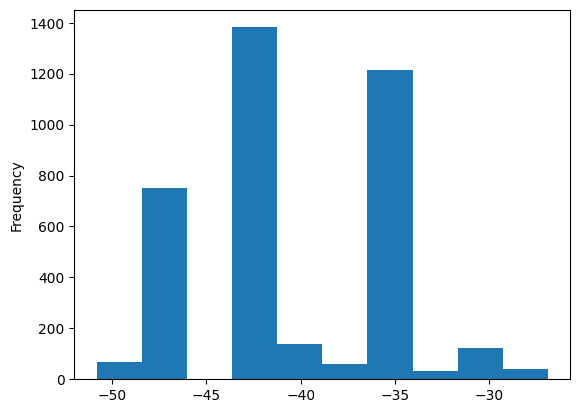

In [67]:
dataset[col].plot.hist();

In [68]:
# Calculating p_value of the column
p_value = kstest(dataset[col], norm(loc=dataset[col].mean(), scale=dataset[col].std()).cdf)[1]

if p_value > 0.05:
    print(Color.GREEN + f'"{col}" column has a normal distribution. \nSig: {p_value}\n')
else:
    print(Color.RED + f'"{col}" column does not have a normal distribution. \nSig: {p_value}\n')

"cons.conf.idx" column does not have a normal distribution. 
Sig: 1.2528212317252459e-116



### Column 'euribor3m'

#### Boxplot

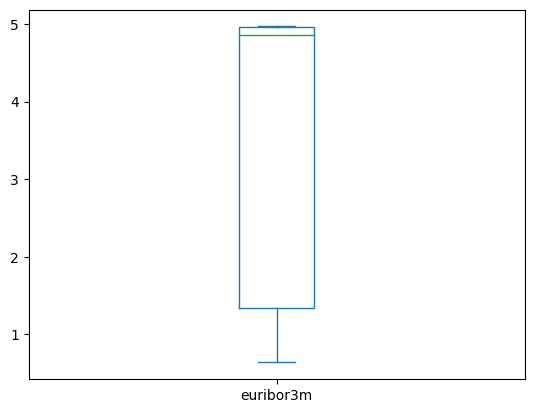

In [69]:
col = cols_numer[8]

dataset[col].plot.box();

In [70]:
dataset[col].describe()

count    3807.000000
mean        3.626664
std         1.727030
min         0.635000
25%         1.334000
50%         4.857000
75%         4.961000
max         4.970000
Name: euribor3m, dtype: float64

#### Histogram & K-S test

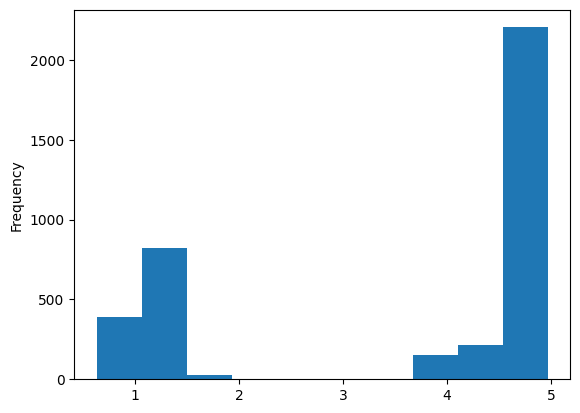

In [71]:
dataset[col].plot.hist();

### Column 'nr.employed'

#### Boxplot

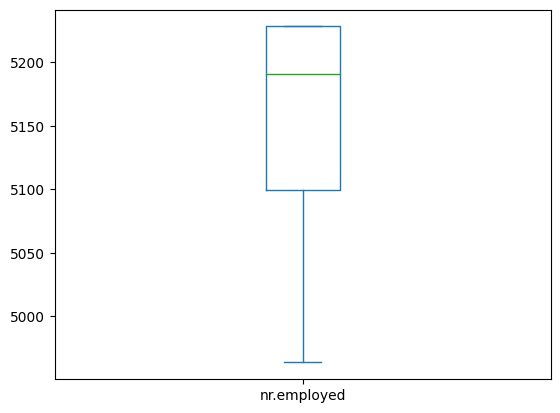

In [72]:
col = cols_numer[9]

dataset[col].plot.box();

In [73]:
dataset[col].describe()

count    3807.000000
mean     5167.013081
std        73.162298
min      4963.600000
25%      5099.100000
50%      5191.000000
75%      5228.100000
max      5228.100000
Name: nr.employed, dtype: float64

#### Histogram & K-S test

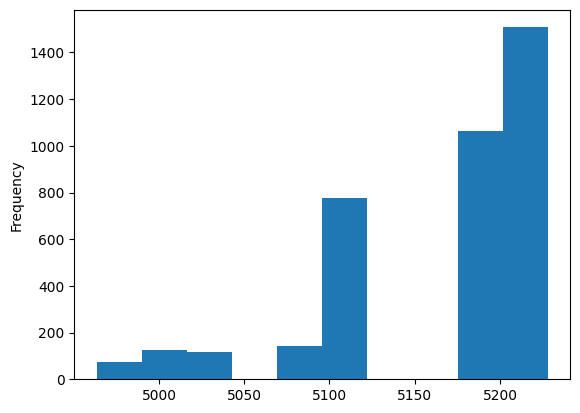

In [74]:
dataset[col].plot.hist();

## Saving cleaned data to a separate file

In [75]:
file_processed = 'data/bank-additional-processed.csv'

dataset.to_csv(file_processed, sep=";", index=False)